In [1]:
import pandas as pd
import numpy as np
base = "../../data/"
target = pd.read_csv(base+"processed/cleaned_target.csv")
target.columns

Index(['Year', 'Type', 'LGA', 'Assault - domestic violence',
       'Assault - non-domestic violence', 'Sexual Offences', 'Robbery',
       'Break and enter dwelling', 'Break and enter non-dwelling',
       'Motor vehicle theft', 'Steal from motor vehicle',
       'Steal from retail store', 'Steal from dwelling', 'Steal from person',
       'Fraud', 'Malicious damage to property', 'Harassment threatening',
       'Receiving stolen goods', 'Other theft', 'Arson',
       'Possession use of cannabis', 'Prohibited weapons offences', 'Trespass',
       'Offensive conduct', 'Offensive language', 'Liquor offences',
       'Breach AVO', 'Breach bail conditions', 'Resist or hinder officer',
       'Transport regulatory offences'],
      dtype='object')

In [2]:
target["Type"].unique()

array(['Total', 'Rate per 100,000 population', 'Rank'], dtype=object)

In [3]:
nswdf_target = target[target["Type"]=='Rate per 100,000 population'].dropna()

In [4]:
opal_df = pd.read_csv(base+"processed/opal_lgas.csv")
opal_lgas = opal_df["lga"].unique()

/Users/tdm/git/capstone/venv/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
import datetime
opal_df["dayofweek"] = opal_df["date"].apply(lambda x: datetime.datetime.strptime(str(x), "%Y%M%d").weekday())

In [6]:
set(opal_lgas).difference(set(nswdf_target["LGA"].unique()))

set()

In [7]:
# log it
start_col = nswdf_target.columns.get_loc('Assault - domestic violence')
for i in range(27):
    nswdf_target = nswdf_target.replace(0.0, 0.01)
    nswdf_target.iloc[:,start_col+i] = np.log(nswdf_target.iloc[:,start_col+i])
    
#print(nswdf_target["pop_class"])
#nswdf_target["pop_class"].hist()

nswdf_target = nswdf_target[(nswdf_target["LGA"].isin(opal_lgas)) & (nswdf_target["Year"] == 2016)]

In [8]:
nswdf_target.columns

Index(['Year', 'Type', 'LGA', 'Assault - domestic violence',
       'Assault - non-domestic violence', 'Sexual Offences', 'Robbery',
       'Break and enter dwelling', 'Break and enter non-dwelling',
       'Motor vehicle theft', 'Steal from motor vehicle',
       'Steal from retail store', 'Steal from dwelling', 'Steal from person',
       'Fraud', 'Malicious damage to property', 'Harassment threatening',
       'Receiving stolen goods', 'Other theft', 'Arson',
       'Possession use of cannabis', 'Prohibited weapons offences', 'Trespass',
       'Offensive conduct', 'Offensive language', 'Liquor offences',
       'Breach AVO', 'Breach bail conditions', 'Resist or hinder officer',
       'Transport regulatory offences'],
      dtype='object')

In [9]:
outdfs = []
for weekday in range(7):
    for tod in ("night", "morning", "afternoon", "evening"):
        for tap in ("on","off"):
            aggdf = opal_df[(opal_df["dayofweek"]==weekday) & (opal_df[tod]==1) & (opal_df["tap"]==tap)].groupby(["lga"]).sum()[["count"]]
            aggdf = aggdf.rename(columns={"count": "{0},{1},{2}".format(weekday,tod,tap)})
            outdfs.append(aggdf)

In [10]:
featuredf = outdfs[0]
for df in outdfs[1:]:
    featuredf = featuredf.join(df, how="outer")
featuredf = featuredf.fillna(0)

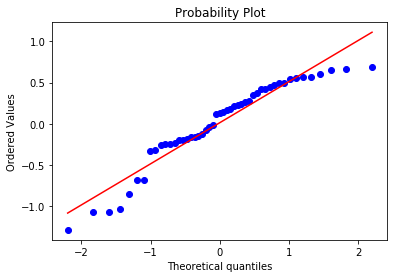

([0.4870709949980309,
  0.47720565550199295,
  0.4691039411472949,
  0.32708294455147474,
  0.6957366441268101,
  0.5005404593752144],
 [0.33467701055898436,
  -0.09074630030627384,
  -0.07561094682468394,
  0.4499236103514007,
  0.2153034795040244,
  0.2579808876424158])

In [52]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import probplot
from sklearn.metrics import r2_score
from matplotlib import pyplot as plt

def kfold_cv(k, crimenum, dataframe, target):
    lga_names = target["LGA"].unique()
    start_col = target.columns.get_loc('Assault - domestic violence')
    kf = KFold(n_splits=5, shuffle=True)
    models = []
    rmse = []
    r2 = []
    allpreds = target.iloc[0:0]
    allpreds["preds"] = pd.Series()
    output = pd.DataFrame(index=range(len(dataframe)))
    for train_index, test_index in kf.split(lga_names):
        train_lgas = lga_names[train_index]
        traindf = dataframe.loc[train_lgas]
        train_target = target.loc[target["LGA"].isin(train_lgas)]
        
        test_lgas = lga_names[test_index]
        testdf = dataframe.loc[test_lgas]
        test_target = target.loc[target["LGA"].isin(test_lgas)].copy()
        #import pdb; pdb.set_trace()
        model = RandomForestRegressor()
        model.fit(traindf, train_target.iloc[:,start_col+crimenum])
        models.append(model)
        #print(lga_loc)
        preds = model.predict(testdf)
        test_target["preds"] = preds
        #import pdb; pdb.set_trace()
        allpreds = pd.concat([allpreds, test_target])
        #is this a fair measure
        rmse.append(np.sqrt(mean_squared_error(preds, test_target.iloc[:,start_col+crimenum])))
        r2.append(r2_score(test_target.iloc[:,start_col+crimenum], preds))

    probplot(allpreds.iloc[:,start_col+crimenum] - allpreds.iloc[:,-1], dist='norm', plot=plt)
    #import pdb; pdb.set_trace()
    plt.show()
   
    rmse.append(np.sqrt(mean_squared_error(allpreds["preds"], allpreds.iloc[:,start_col+crimenum])))
    r2.append(r2_score(allpreds.iloc[:,start_col+crimenum], allpreds["preds"]))
    return output, rmse, r2, models, allpreds

output = kfold_cv(5, 0, featuredf, nswdf_target)
output[1:3]

In [46]:
allpreds = output[-1]
allpreds.columns
#allpreds["resid"] = allpreds["preds"] - allpreds.loc[:,"Assault - domestic violence"]

Index(['0,night,on', '0,night,off', '0,morning,on', '0,morning,off',
       '0,afternoon,on', '0,afternoon,off', '0,evening,on', '0,evening,off',
       '1,night,on', '1,night,off', '1,morning,on', '1,morning,off',
       '1,afternoon,on', '1,afternoon,off', '1,evening,on', '1,evening,off',
       '2,night,on', '2,night,off', '2,morning,on', '2,morning,off',
       '2,afternoon,on', '2,afternoon,off', '2,evening,on', '2,evening,off',
       '3,night,on', '3,night,off', '3,morning,on', '3,morning,off',
       '3,afternoon,on', '3,afternoon,off', '3,evening,on', '3,evening,off',
       '4,night,on', '4,night,off', '4,morning,on', '4,morning,off',
       '4,afternoon,on', '4,afternoon,off', '4,evening,on', '4,evening,off',
       '5,night,on', '5,night,off', '5,morning,on', '5,morning,off',
       '5,afternoon,on', '5,afternoon,off', '5,evening,on', '5,evening,off',
       '6,night,on', '6,night,off', '6,morning,on', '6,morning,off',
       '6,afternoon,on', '6,afternoon,off', '6,evening,

In [ ]:
featuredf.iloc[0,np.argsort(output[3][-2].feature_importances_)]